# Train a BNN to classify MNIST

In [1]:
# for leonhard
import os
# os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
# os.environ['XLA_FLAGS']

In [2]:
%load_ext autoreload
# Train a Bayesian neural network to classify MNIST using
# (parallel) Langevin dynamics
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")
import argparse
import matplotlib.pyplot as plt
import numpy as onp
import jax.numpy as jnp

from jax import jit, value_and_grad, vmap, random
from tqdm import tqdm
import optax
import utils
import config as cfg
import jax.flatten_util
import mnist
import bnn
import metrics

import os
on_cluster = not os.getenv("HOME") == "/home/lauro"

# Config
key = random.PRNGKey(0)
EPOCHS = 1
BATCH_SIZE = 128
LEARNING_RATE = 1e-7
NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False


opt = utils.sgld(LEARNING_RATE)

@jit
def step(param_set, opt_state, images, labels):
    """Update param_set elements in parallel using Langevin dynamics."""
    step_losses, g = vmap(value_and_grad(bnn.loss), (0, None, None))(
        param_set, images, labels)
    g, opt_state = opt.update(g, opt_state, param_set)
    aux = {
        "losses": step_losses,
        "global_grad_norm": optax.global_norm(g), 
    }
    return optax.apply_updates(param_set, g), opt_state, aux

Loading data...


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
%autoreload

# Training with parallel Langevin dynamics

In [17]:
# initialize set of parameters
key, subkey = random.split(key)
param_set = vmap(bnn.model.init, (0, None))(
    random.split(subkey, NUM_SAMPLES), mnist.train_images[:5])
opt_state = opt.init(param_set)

In [18]:
# training loop
n_train_steps = 200
rundata = {}
trajectories = []
accuracies = []

In [19]:
params = bnn.model.init(subkey, mnist.train_images[:5])
utils.leaf_shapes(params)

FlatMapping({
  'conv2_d': FlatMapping({'b': (16,), 'w': (3, 3, 1, 16)}),
  'conv2_d_1': FlatMapping({'b': (8,), 'w': (3, 3, 15, 8)}),
  'linear': FlatMapping({'b': (10,), 'w': (343, 10)}),
})

In [20]:
pflat = jax.flatten_util.ravel_pytree(params)[0]
pflat.shape

(4688,)

In [ ]:
for step_counter in tqdm(range(n_train_steps), disable=DISABLE_PROGRESS_BAR):
    images, labels = next(mnist.training_batches)
    param_set, opt_state, aux = step(param_set, opt_state, images, labels)
    metrics.append_to_log(rundata, aux)
    trajectories.append(vmap(lambda ps: jax.flatten_util.ravel_pytree(ps)[0])(param_set))

    if step_counter % 10 == 0:
        accuracies.append(bnn.compute_acc(param_set))
#         print(f"Step {step_counter}, Accuracy:", accuracies[-1])

 36%|███▋      | 73/200 [1:14:31<1:36:13, 45.46s/it] 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].plot(accuracies, "--.")
axs[1].plot(onp.array(rundata['losses']).mean(axis=1), "--.");

In [ ]:
trajectories_arr = onp.array(trajectories)
print(trajectories_arr.shape)

In [ ]:
# visualize trajectory avg across dimensions (distinguish particles)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories_arr.mean(axis=2));  # avg across dims

ax = axs[1]
ax.plot(trajectories_arr[:, :, 0]);  # watch single param (aka single dimension)

In [ ]:
# visualize trajectory avg across particles (distinguish dims, ie parameters)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories_arr.mean(axis=1)); # avg across particles

ax = axs[1]
ax.plot(trajectories_arr[:, 10, :]); # watch single particle

# Classic (non-Bayesian) training
* Train a classifier using SGD. 
* To be consistent with the BNN approach, all parameters (including biases) are initialized as $N(0, 1/100^2)$ (ie the prior).
* The training loss is $L^2$-regularized, corresponding roughly to the maximum a posteriori estimator with the normal prior.

Note: works fine with networks as small as 2-layer conv with 4 channels per layer (loss decreases steadily and accuracy is ~0.92 after two epochs).

In [8]:
%autoreload

In [9]:
learning_rate = 1e-7
opt = optax.sgd(learning_rate)
# opt = utils.sgld(learning_rate)

@jit
def classic_step(params, opt_state, images, labels):
    step_loss, g = value_and_grad(bnn.loss)(params, images, labels)
    g, opt_state = opt.update(g, opt_state, params)
    return optax.apply_updates(params, g), opt_state, step_loss

@jit
def compute_accuracy(params):
    return bnn.accuracy(bnn.model.apply(params, mnist.val_images[:BATCH_SIZE]), mnist.val_labels[:BATCH_SIZE])


key, subkey = random.split(key)
params = bnn.model.init(subkey, mnist.train_images[:2])
opt_state = opt.init(params)

ls = []
ces = []
accs = []
trajectory = []

pflat = jax.flatten_util.ravel_pytree(params)[0]
pflat.shape

(4688,)

In [10]:
utils.leaf_shapes(params)

FlatMapping({
  'conv2_d': FlatMapping({'b': (16,), 'w': (3, 3, 1, 16)}),
  'conv2_d_1': FlatMapping({'b': (8,), 'w': (3, 3, 15, 8)}),
  'linear': FlatMapping({'b': (10,), 'w': (343, 10)}),
})

In [11]:
for step_count in tqdm(range(200)):
    images, labels = next(mnist.training_batches)
    params, opt_state, step_loss = classic_step(params, opt_state, images, labels)
    trajectory.append(jax.flatten_util.ravel_pytree(params)[0])
    ls.append(step_loss)

    if step_count % 25 == 0:
        current_acc = compute_accuracy(params)
        accs.append(current_acc)

100%|██████████| 200/200 [00:05<00:00, 33.88it/s]


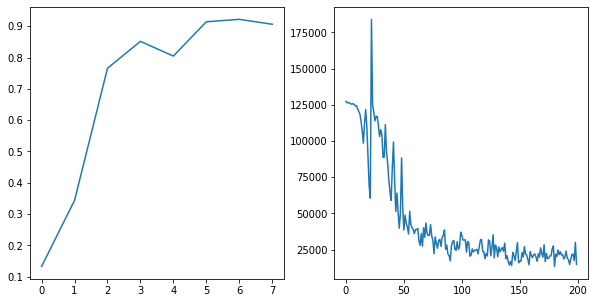

In [12]:
#  strides = 2 for 2., full channels on both, 13k params
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].plot(accs)
axs[1].plot(ls)

In [13]:
onp.mean(accs[-10:])

0.7050781

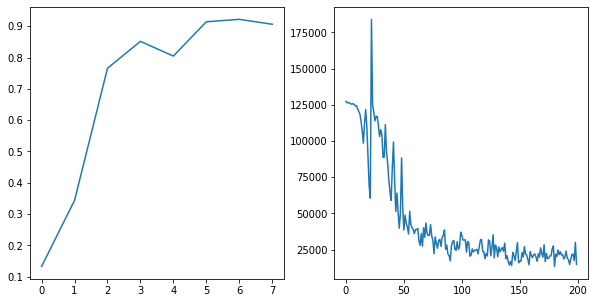

In [14]:
#  strides = 1 for both, half channels on 2., 12k params
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].plot(accs)
axs[1].plot(ls)

In [9]:
onp.mean(accs[-10:])

0.9546875

In [15]:
trajectory_arr = onp.array(trajectory)

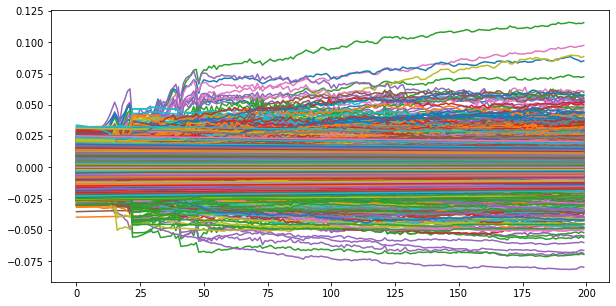

In [16]:
# visualize trajectory of each parameter
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(trajectory_arr);